## Main code

### Libraries and Modules

In [1]:
import sys
import math
import glob
import os
import time
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi
import cv2

import import_ipynb
import voronoi_constructor as vor_build
import vertices_assembler as assembler
import i_o

importing Jupyter notebook from voronoi_constructor.ipynb
importing Jupyter notebook from node_linker.ipynb
importing Jupyter notebook from solver.ipynb
importing Jupyter notebook from vertices_assembler.ipynb
importing Jupyter notebook from i_o.ipynb


### Global Parameters

In [2]:
parameters = {"robots"      : 11,
              "radius"      : 0.1,
              "movement"    : 0.1,
              "tolerance"   : 0.05,
              "deadlock_mov": 0.1,
              "previous"    : 1
             }

### General Options

In [3]:
options = { "palette"    : vor_build.colors(parameters["robots"]),
            "verbose"    : 0,
            "optimize"   : 0,
            "plot"       : 0,
            "save_image" : 0,
            "save_data"  : 0,
            "experiments": 1,
            "seed"       : 13,
            "critical"   : 50,
            "aggregate"  : 0,
            "path_data"  : "/home/leduin/Escritorio/Tesis/Resultados/Datos/",
            "path_image" : "/home/leduin/Escritorio/Tesis/Imagenes/"
          }

### Main Loop

In [4]:
def main_module(key):
    with open(options["path_data"]+"aga_"+key+".csv", "a") as file:
        if options["save_data"]:
            csv_writer = csv.writer(file)
        for experiment in range(options["experiments"]):
            # INITIALIZATION
            start_time = time.time()
            inst_experiment = experiment+options["seed"]
            pos = vor_build.pos_gen(parameters["robots"], inst_experiment)
            vor_init = Voronoi(pos["init"])
            vor_fin  = Voronoi(pos["fin"])
            robots_path = [] # To save the robots path along execution
            finished = np.all(pos["init"] == pos["fin"]) 
            # To save the traveled distance of each robot 
            traveled_distances = [0 for _ in range(parameters["robots"])]
            counter = 0 # For steps
            
            # COLLISION FREE CONFIGURATION
            if vor_build.collision(pos["init"], vor_init.ridge_points,
                                   parameters["radius"]):
                print('ERROR!: Change the initial configuration')
                print("Positions:", vor_init.ridge_points)
                break
            if vor_build.collision(pos["fin"], vor_fin.ridge_points,
                                   parameters["radius"]):
                print('ERROR!: Change the final configuration')
                print("Positions:", vor_fin.ridge_points)
                break
                
            # MAIN LOOP
            while not finished:
                #Final iteration
                if np.all(pos["init"] == pos["fin"]):
                    finished = True
                if options["verbose"]:
                    print("==================================================")
                    print('                    MAIN DATA')
                    print("==================================================")
                    print('Robots:\n', pos["init"],'\n')
                    print('Final positions:\n', pos["fin"],'\n')
                    print("Colors:")
                    for color in options["palette"]:
                        print(color)
                    print("\n")
                # Generate Voronoi Diagram for the current positions
                vor_init = Voronoi(pos["init"])
                # Generate the Voronoi Diagram and get the approximated values
                # of inf vertices
                vor_approx = vor_build.voronoi_approx(pos["init"], vor_init,
                                                      options["verbose"])
                # Assemble the vertices and get the ordered vertices
                vrtx_assembled = assembler.main(parameters["robots"], vor_init,
                                                vor_approx["edge"],
                                                options["verbose"])
                robots_path.append(pos["init"]) # Save the previous position
                # Generate the BVC
                bvc = vor_build.bvc_gen(pos, parameters["radius"], vor_approx,
                                        vrtx_assembled, robots_path, options)
                i_o.save_image(options, parameters, counter)
                
                # DEADLOCK TESTING
                bvc["closer"],list_deadlock=vor_build.deadlock_test(parameters,
                                                                    options,
                                                                    bvc, pos,
                                                                    counter,
                                                                    robots_path)
                if options["verbose"]:
                    print('\nRounds: ',counter)
                    print('\n*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*\n')
                counter += 1
                if counter == options["critical"]:
                    options["verbose"] = 1
                    options["plot"] = 1
                if counter > options["critical"] + options["aggregate"]:
                    options["verbose"] = 0
                    options["plot"] = 0
                # UPDATING POSITIONS
                internal_paths = bvc["closer"] - pos["init"]
                new_positions = []
                for i in range(parameters["robots"]):
                    if np.all(internal_paths[i] == 0):
                        # Paralyzed Robot for deadlock
                        if i in list_deadlock: 
                            new_positions.append(bvc["closer"][i])
                        else: # Reached target
                            new_positions.append(pos["fin"][i])
                    else:
                        candidate = (pos["init"][i] +
                                     ((internal_paths[i]
                                       / np.linalg.norm(internal_paths[i]))
                                      * parameters["movement"]))
                        # Reaching the final position
                        if vor_build.isBetween(pos["init"][i], candidate,
                                                 pos["fin"][i]):
                            new_positions.append(pos["fin"][i])
                            traveled_distances[i]+=np.linalg.norm(pos["init"][i]
                                                                  - pos["fin"][i])
                        # Internal Path less than alpha
                        elif (np.linalg.norm(internal_paths[i])
                              < parameters["movement"]):
                            new_positions.append(bvc["closer"][i])
                            traveled_distances[i]+=np.linalg.norm(internal_paths[i])
                        # Normal movement
                        else:
                            new_positions.append(candidate)
                            traveled_distances[i] += parameters["movement"]
                pos["init"] = np.array(new_positions)
            effectiveness = np.sum(pos["dist"]) / np.sum(traveled_distances)
            if options["save_data"]:
                csv_writer.writerow([parameters[key], inst_experiment,
                                     counter, time.time() - start_time,
                                     effectiveness])
            print('Experiment ' + str(inst_experiment) + " done!")

### Running for the stablished number of experiments

                    MAIN DATA
Robots:
 [[ 0.27257778  0.10804172]
 [ 0.17637145  0.53660114]
 [-0.09756189  0.37260493]
 [-0.34934082  0.11946531]
 [-0.54315205 -0.10642753]
 [-0.11966455 -0.08889751]
 [-0.39171385 -0.35237321]
 [-0.09800464 -0.59013511]
 [-0.13870229 -0.33925189]
 [ 0.07654775 -0.26637017]
 [-0.02740549  0.12972498]] 

Final positions:
 [[-4.73 -0.01]
 [-4.03 -2.59]
 [-2.17 -4.43]
 [ 0.52 -4.72]
 [ 2.85 -3.69]
 [ 4.35 -1.34]
 [ 4.42  1.29]
 [ 3.03  3.33]
 [ 0.55  4.63]
 [-2.01  4.11]
 [-3.96  2.36]] 

Colors:
red
orangered
goldenrod
yellowgreen
green
teal
aqua
blue
purple
magenta
maroon


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.32947147 -0.14445219]
1 .- [-0.27260568 -0.20316842]
2 .- [-0.05932388 -0.21938704]
3 .- [-0.25786913 -0.48732538]
4 .- [ 0.01633676 -0.44284438]
5 .- [ 0.11068824 -0.04572158]
6 .- [ 0.09372971 -0.05017226]
7 .- [0.13585297 0.30242696]
8 .- [0.12821958 0.30625001]
9 .- [-0.1912217  0.2139787]
10 .- [

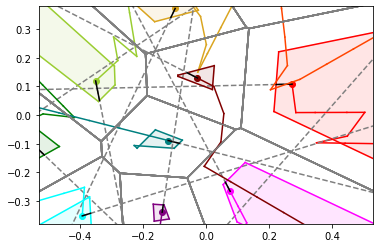

Distance from red to the closest point: 0.05061478107409292
Distance from the 1th previous point: 0.05061478107409292
Distance from orangered to the closest point: 0.059933677616037746
Distance from the 1th previous point: 0.08255804268566659
Distance from goldenrod to the closest point: 0.034196413098708155
Distance from the 1th previous point: 0.09337196761513053
Distance from yellowgreen to the closest point: 0.06948821679853959
Distance from the 1th previous point: 0.15109031096162748
Distance from green to the closest point: 0.045376281573722796
Distance from the 1th previous point: 0.1349734304234793
Distance from teal to the closest point: 0.0360711059653567
Distance from the 1th previous point: 0.09515373665880777
Distance from aqua to the closest point: 0.02773386375383699
Distance from the 1th previous point: 0.02773386375383699
Distance from blue to the closest point: 0.04031767646503501
Distance from the 1th previous point: 0.12796443651423514
Distance from purple to the cl

In [5]:
main_module("robots")

### One Parameter Analysis

In [15]:
parameter = "robots"
print("Working on",parameter,"...")
previous_value = parameters[parameter]
if parameter == "deadlock_mov":
    parameters[parameter] = 1
elif parameter == "tolerance":
    parameters[parameter] = 0.1
elif parameter == "movement":
    parameters[parameter] = 20
for i in range(10):
    print(parameter,"equal to",parameters[parameter],"...")
    main_module(parameter)
    if parameter == "tolerance":
        parameters[parameter] = round(parameters[parameter]+0.1,2)
    elif parameter == "movement":
        parameters[parameter] += 10 
    else:
        parameters[parameter] += 1
parameters[parameter] = previous_value

Working on num_robots ...
num_robots equal to 5 ...
num_robots equal to 6 ...
num_robots equal to 7 ...
num_robots equal to 8 ...


KeyboardInterrupt: 

### All Parameter Analysis

In [8]:
for parameter in parameters:
    print("Working on",parameter,"...")
    previous_value = parameters[parameter]
    if parameter == "deadlock_mov":
        parameters[parameter] = 1
    for i in range(10):
        print(parameter,"equal to",parameters[parameter],"...")
        main_module(parameter)
        parameters[parameter] += 1
    parameters[parameter] = previous_value

Working on robots ...
robots equal to 5 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!


voronoi_constructor.ipynb:16: RuntimeWarning: invalid value encountered in double_scalars
  },


Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 6 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 7 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment

KeyboardInterrupt: 

### Generate Video

In [11]:
frameSize = (432, 288)

out = cv2.VideoWriter('/home/leduin/Desktop/Hub/Images/Simple/animation_simple_'
                      +str(robots)+'.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 4, frameSize)

for filename in sorted(glob.glob('/home/leduin/Desktop/Hub/Images/Simple/'
                                 +str(robots)+'/*.png'),
                       key=os.path.getmtime):
    img = cv2.imread(filename)
    out.write(img)

out.release()